In [1]:
import json
from argparse import Namespace
from collections import OrderedDict

import torch
import transformers
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

from utils.common import test_step
from utils.data_utils import get_data_loader
from models.multimodal_classifiers import MultiModalClassifier, MultiModalClassifierAdapter

transformers.logging.set_verbosity_error()

Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2Model: ['lm_head.weight', 'lm_head.bias']
- This IS expected if you are initializing Wav2Vec2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## [0] test set, test model path 설정

In [2]:
test_config = OrderedDict({
    'task_a': {
        'KEMDy19': {
            'fold_0': './outputs/task_a/fold_0/KEMDy19/best_model.pt',
            'fold_1': './outputs/task_a/fold_1/KEMDy19/best_model.pt',
            'fold_2': './outputs/task_a/fold_2/KEMDy19/best_model.pt',
            'fold_3': './outputs/task_a/fold_3/KEMDy19/best_model.pt',
            'fold_4': './outputs/task_a/fold_4/KEMDy19/best_model.pt'
        },
        'KEMDy20': {
            'fold_0': './outputs/task_a/fold_0/KEMDy20/best_model.pt',
            'fold_1': './outputs/task_a/fold_1/KEMDy20/best_model.pt',
            'fold_2': './outputs/task_a/fold_2/KEMDy20/best_model.pt',
            'fold_3': './outputs/task_a/fold_3/KEMDy20/best_model.pt',
            'fold_4': './outputs/task_a/fold_4/KEMDy20/best_model.pt'
        }
    },
    'finetune': {
        'KEMDy19': { # testset / task a
            'fold_0': './outputs/finetune/fold_0/KEMDy20/best_model.pt',
            'fold_1': './outputs/finetune/fold_1/KEMDy20/best_model.pt',
            'fold_2': './outputs/finetune/fold_2/KEMDy20/best_model.pt',
            'fold_3': './outputs/finetune/fold_3/KEMDy20/best_model.pt',
            'fold_4': './outputs/finetune/fold_4/KEMDy20/best_model.pt'
        },
        'KEMDy20': {
            'fold_0': './outputs/finetune/fold_0/KEMDy19/best_model.pt',
            'fold_1': './outputs/finetune/fold_1/KEMDy19/best_model.pt',
            'fold_2': './outputs/finetune/fold_2/KEMDy19/best_model.pt',
            'fold_3': './outputs/finetune/fold_3/KEMDy19/best_model.pt',
            'fold_4': './outputs/finetune/fold_4/KEMDy19/best_model.pt'
        }
    },
    'ewc': {
        'KEMDy19': {
            'fold_0': './outputs/ewc/fold_0/KEMDy20/best_model.pt',
            'fold_1': './outputs/ewc/fold_1/KEMDy20/best_model.pt',
            'fold_2': './outputs/ewc/fold_2/KEMDy20/best_model.pt',
            'fold_3': './outputs/ewc/fold_3/KEMDy20/best_model.pt',
            'fold_4': './outputs/ewc/fold_4/KEMDy20/best_model.pt'
        },
        'KEMDy20': {
            'fold_0': './outputs/ewc/fold_0/KEMDy19/best_model.pt',
            'fold_1': './outputs/ewc/fold_1/KEMDy19/best_model.pt',
            'fold_2': './outputs/ewc/fold_2/KEMDy19/best_model.pt',
            'fold_3': './outputs/ewc/fold_3/KEMDy19/best_model.pt',
            'fold_4': './outputs/ewc/fold_4/KEMDy19/best_model.pt'
        }
    },
    'adapter': {
        'KEMDy19': {
            'fold_0': './outputs/adapter/fold_0/best19_model.pt',
            'fold_1': './outputs/adapter/fold_1/best19_model.pt',
            'fold_2': './outputs/adapter/fold_2/best19_model.pt',
            'fold_3': './outputs/adapter/fold_3/best19_model.pt',
            'fold_4': './outputs/adapter/fold_4/best19_model.pt'
        },
        'KEMDy20': {
            'fold_0': './outputs/adapter/fold_0/best20_model.pt',
            'fold_1': './outputs/adapter/fold_1/best20_model.pt',
            'fold_2': './outputs/adapter/fold_2/best20_model.pt',
            'fold_3': './outputs/adapter/fold_3/best20_model.pt',
            'fold_4': './outputs/adapter/fold_4/best20_model.pt'
        }
    },
    'adapter_wo_pretraining': {
        'KEMDy19': {
            'fold_0': './outputs/adapter_wo_pretraining/fold_0/best19_model.pt',
            'fold_1': './outputs/adapter_wo_pretraining/fold_1/best19_model.pt',
            'fold_2': './outputs/adapter_wo_pretraining/fold_2/best19_model.pt',
            'fold_3': './outputs/adapter_wo_pretraining/fold_3/best19_model.pt',
            'fold_4': './outputs/adapter_wo_pretraining/fold_4/best19_model.pt'
        },
        'KEMDy20': {
            'fold_0': './outputs/adapter_wo_pretraining/fold_0/best20_model.pt',
            'fold_1': './outputs/adapter_wo_pretraining/fold_1/best20_model.pt',
            'fold_2': './outputs/adapter_wo_pretraining/fold_2/best20_model.pt',
            'fold_3': './outputs/adapter_wo_pretraining/fold_3/best20_model.pt',
            'fold_4': './outputs/adapter_wo_pretraining/fold_4/best20_model.pt'
        }
    }
})

In [3]:
with open('./test_config.json', 'w') as f:
    json.dump(test_config, f, indent=2, ensure_ascii=True)

## [1] 테스트셋 점수 계산

In [4]:
with open('./test_config.json') as f:
    test_config = json.load(f)

In [5]:
def calculate_score(test_set, checkpoint_path, fold, device='cuda'):
    key = f'{test_set}-{fold}'
    if key in dl_cache:
        test_dl = dl_cache[key]
    else:
        data_root = './data/KEMDy19' if test_set == 'KEMDy19' else './data/KEMDy20'
        num_fold = int(fold[-1])
        args = Namespace(max_text_len=256, max_seq_len=5, k_fold=5, num_fold=num_fold, batch_size=16, seed=12)
        train_dl, valid_dl, test_dl = get_data_loader(data_root=data_root,
                                                      max_text_len=args.max_text_len,
                                                      max_seq_len=args.max_seq_len,
                                                      k_fold=args.k_fold,
                                                      fold=args.num_fold,
                                                      batch_size=args.batch_size,
                                                      seed=args.seed)
        dl_cache[key] = test_dl
    
    task_id = None
    if 'adapter' in checkpoint_path:
        task_id = 0 if test_set == 'KEMDy19' else 1
    
    model = MultiModalClassifierAdapter() if 'adapter' in checkpoint_path else MultiModalClassifier()
    model = model.to(device)
    model.load_state_dict(torch.load(checkpoint_path))
    
    outputs = test_step(test_dl, model, device, task_id)
    return outputs

In [8]:
dl_cache = {}
test_result = OrderedDict()

for test_model in test_config.keys():
    test_set_dict = test_config.get(test_model)
    if test_model not in test_result:
        test_result[test_model] = {}
    
    for test_set in test_set_dict.keys():
        fold_dict = test_set_dict.get(test_set)
        if test_set not in test_result[test_model]:
            test_result[test_model][test_set] = {}
        
        for fold in fold_dict.keys():  # fold
            checkpoint_path = fold_dict.get(fold)
            outputs = calculate_score(test_set, checkpoint_path, fold)
            
            test_result[test_model][test_set][fold] = {
                'f1_micro': outputs['f1_micro'],
                'f1_macro': outputs['f1_macro'],
                'f1_weighted': outputs['f1_weighted']
            }

In [9]:
with open('test_result.json', 'w') as f:
    json.dump(test_result, f, indent=2)

## [2] 그림 2 파괴적 망각 방지 성능 비교

In [10]:
with open('test_result.json', 'r') as f:
    test_result = json.load(f)

In [12]:
metric = 'f1_weighted'
result_dict = OrderedDict()

for test_model in test_result:
    test_set_dict = test_result.get(test_model)
    if test_model not in result_dict:
        result_dict[test_model] = {}
    
    for test_set in test_set_dict.keys():
        fold_dict = test_set_dict.get(test_set)
        if test_set not in result_dict[test_model]:
            result_dict[test_model][test_set] = 0.0
        
        score = np.mean([score_dict.get(metric) for score_dict in fold_dict.values()])
        
        result_dict[test_model][test_set] = score

In [13]:
pd.DataFrame(result_dict)

,task_a,finetune,ewc,adapter,adapter_wo_pretraining
KEMDy19,0.70389,0.524502,0.599862,0.681204,0.510747
KEMDy20,0.87122,0.765711,0.761987,0.847727,0.833978


In [14]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
before_color = colors[0]
after_color = colors[1]

In [15]:
def draw(result_dict, test_set, title, ylabel):
    x_labels = ['finetuning', 'ewc', 'ours', 'w/o_pretrain']
    bar_width = 0.4
    
    before_models = ['task_a', 'task_a', 'adapter', 'adapter_wo_pretraining']
    before = [result_dict[test_model][test_set] for test_model in before_models]
    
    after_models = ['finetune', 'ewc', 'adapter', 'adapter_wo_pretraining']
    after = [result_dict[test_model][test_set] for test_model in after_models]
    
    plt.bar(np.arange(4) + bar_width, before, width=bar_width, color=before_color)
    plt.bar(np.arange(4) + bar_width * 2, after, width=bar_width, color=after_color)
    
    plt.axhline(before[0], linestyle='--', color=before_color)
    plt.axhline(after[0], linestyle='--', color=after_color)
    
    plt.title(title, fontsize=15)
    plt.ylabel(ylabel, fontsize=14)
    plt.xticks(np.arange(4) + bar_width * 3 / 2, x_labels, fontsize=13)

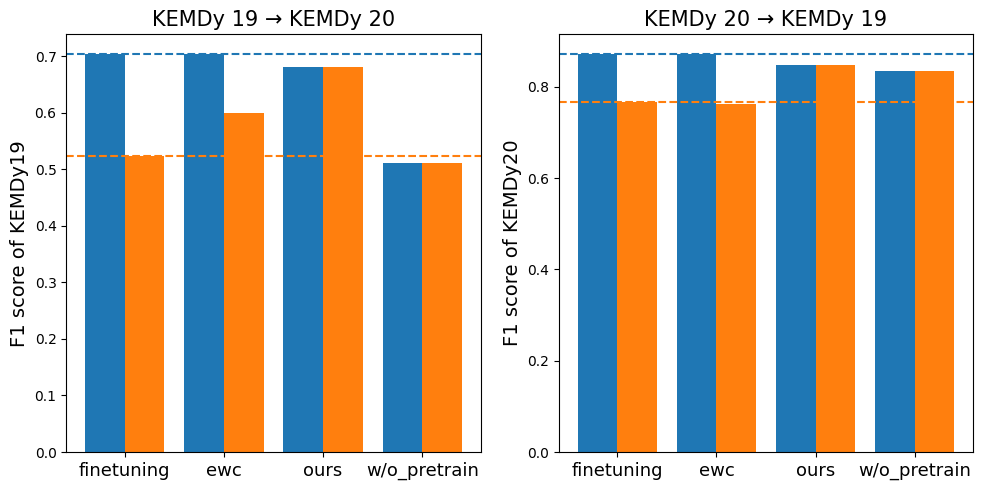

In [17]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
draw(result_dict, test_set='KEMDy19', title='KEMDy 19 → KEMDy 20', ylabel='F1 score of KEMDy19')
plt.subplot(1, 2, 2)
draw(result_dict, test_set='KEMDy20', title='KEMDy 20 → KEMDy 19', ylabel='F1 score of KEMDy20')

plt.tight_layout()
plt.savefig('figures/fig2.png')
plt.show()

## [3] 그림 3 사전학습 여부에 따른 혼동 행렬

In [18]:
with open('./test_config.json') as f:
    test_config = json.load(f)

In [19]:
def calculate_confusion_matrix(test_set, fold_dict):
    y_true = []
    y_pred = []

    for fold in fold_dict:
        checkpoint_path = fold_dict[fold]
        outputs = calculate_score(test_set, checkpoint_path, fold)

        y_true.extend(outputs['y_true'])
        y_pred.extend(outputs['y_pred'])

    conf_mat = confusion_matrix(y_true, y_pred, normalize='true')
    return conf_mat

In [20]:
conf_mat_with_pretrain = calculate_confusion_matrix('KEMDy20', fold_dict=test_config['adapter']['KEMDy20'])
conf_mat_without_pretrain = calculate_confusion_matrix('KEMDy20', fold_dict=test_config['adapter_wo_pretraining']['KEMDy20'])

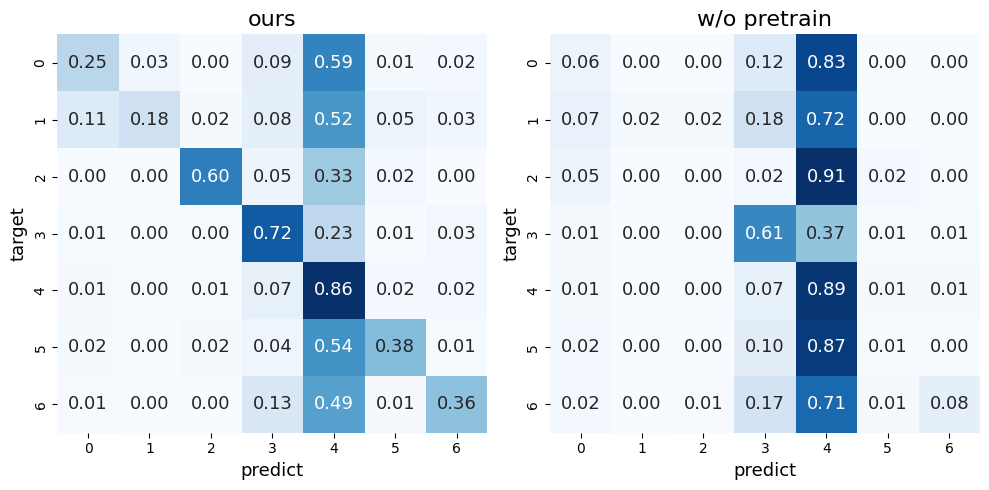

In [22]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.heatmap(conf_mat_with_pretrain, annot=True, fmt='.2f', cmap='Blues', cbar=False, annot_kws={"size": 13})
plt.title('ours', fontsize=16)
plt.xlabel('predict', fontsize=13)
plt.ylabel('target', fontsize=13)

plt.subplot(1, 2, 2)
sns.heatmap(conf_mat_without_pretrain, annot=True, fmt='.2f', cmap='Blues', cbar=False, annot_kws={"size": 13})
plt.title('w/o pretrain', fontsize=16)
plt.xlabel('predict', fontsize=13)
plt.ylabel('target', fontsize=13)
plt.tight_layout()
plt.savefig('./figures/fig3.png')
plt.show()

## [4] 그림 4 방법론 별 확장성 비교

In [25]:
model = MultiModalClassifier()
finetune_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model = MultiModalClassifierAdapter()
adapter_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

In [26]:
# 모델 학습 파라미터
finetune_total_params, adapter_total_params

(205193095, 26483214)

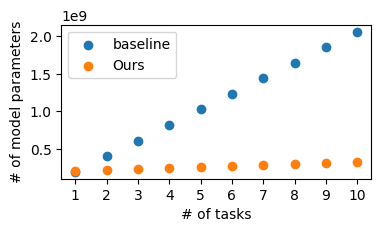

In [28]:
t = np.arange(10) + 1

base = lambda x: finetune_total_params * x
ours = lambda x: finetune_total_params + x * adapter_total_params / 2

plt.figure(dpi=100, figsize=(4,2))
plt.scatter(t, base(t), label='baseline')
plt.scatter(t, ours(t), label='Ours')
plt.xticks(t)
plt.legend()
plt.ylabel('# of model parameters')
plt.xlabel('# of tasks')
plt.savefig('./figures/fig4.png', bbox_inches = 'tight')
plt.show()